<a href="https://colab.research.google.com/github/vijaikrish/Rotor_balancing/blob/master/Genetic_algorithm_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from numpy.random import randint
from numpy.random import rand
import random
import numpy as np
from itertools import groupby
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [16]:
# Importing the data
Blade_data = np.genfromtxt('drive/MyDrive/blade data/blade_data.csv', delimiter=',')
# print(len(Blade_data[:, 0]))   # row represents the blade number column represents the blade weight
Total_blade = len(Blade_data[:, 0]) - 1  # Total number of blades calculation
n = Total_blade
r = 1  # radius of the disk in mm

In [19]:
# Fitness function
## Mass moment (Residual unbalance) is calculated
def fitness(x):
    m_x = np.zeros(n)
    m_y = np.zeros(n)
    # Calculate the unbalance of the total system in iterative loop
    for j in range(0, n):
        m_x[j] = Blade_data[x[j], 1] * r * np.cos((360 * j/n))
        # m_y[j] = Blade_data[x[j], 1] * r * np.sin((2 * 180 * j) / n)
        m_y[j] = Blade_data[x[j], 1] * r * np.sin((360 * j/n))
        # print(x[j])

    M_x = np.sum(m_x)
    M_y = np.sum(m_y)
    res_un = np.sqrt(M_x**2 + M_y**2)
    # print (res_un)
    fit_float = 10/res_un
    fit = round(fit_float, 4)
    # print (fit)
    return fit


In [5]:
# Parent selection
## Roulette wheel selection is preferred for the parent selection 
## 1. Fitness value is calculated for all the population 
## 2. Relative fitness value is calculated
## 3. Probability of the population range is calculated from 0 to 1
## 4. Randon number is selected from the range 0-1
## 5. Based on the random number the 2 parent is selected
def selection(scores):
    ## Fitness value calculation f(x_i)
    f = scores
    # print(pop)
    relative_fitness = []
    ## Relative fitness calculation p(i)
    for k in range(n_pop):
        pi = f[k] / sum(f)
        relative_fitness.append(pi)  # P is the relative fitness function
    ## Probability weight calculation 
    probability = [sum(relative_fitness[:i + 1]) for i in range(len(relative_fitness))]
    # Roulette based selection
    ## Random selection betwen 0-1
    random =np.random.random(2)
    ## Parent selection based on the random number
    parent = np.zeros(2)
    for i in range (len(random)):
      for j in range (n_pop):
        if random[i]<probability[j]:
          parent[i]= j
          break
    # parent.astype(np.int64)
    return parent


In [6]:
# crossover two parents to create two offspring (Children)
# Recombination crossover operator 
# Gets edges for parent1, parent2

def find_edges(parent1, parent2):
  parent1_edges = calc_edges(parent1)
  parent2_edges = calc_edges(parent2)
  merged_edges = merge_edges(parent1_edges, parent2_edges)  

  return (parent1_edges, parent2_edges, merged_edges)

#calculates edges for an individual
def calc_edges(individual):
  edges = []
  
  for position in range(len(individual)):
    if position == 0:
      edges.append([individual[position], (individual[-1], individual[position+1])])
    elif position < len(individual)-1:
      edges.append([individual[position], (individual[position-1], individual[position+1])])
    else:
      edges.append([individual[position], (individual[position-1], individual[0])])
  
  return edges

#sort the edges    
def sort_edges(individual):
  individual.sort()

#perform an union on two parents
def merge_edges(parent1, parent2):
  sort_edges(parent1)
  sort_edges(parent2)

  edges = []
  for val in range(len(parent1)):
    edges.append([parent1[val][0], union(parent1[val][1], parent2[val][1])])
  
  return edges

#part of merge_edges - unions 2 individual
def union(individual1, individual2):
  edges = list(individual1)

  for val in individual2:
    if val not in edges:
      edges.append(val)
  return edges



In [7]:
#Edge recombination operator 
def crossover(parent1, parent2, edges):
  k = []
  previous = None
  current = random.choice([parent1[0], parent2[0]])

  while True:
    k.append(current)

    if(len(k) == len(parent1)):
      break
    
    previous = remove_node_from_neighbouring_list(current, edges)
    current_neighbour = get_current_neighbour(previous, edges)

    next_node = None
    if len(current_neighbour) > 0:
      next_node = get_best_neighbour(current_neighbour)
    else:
      next_node = get_next_random_neighbour(k, edges)
   
    current = next_node[0]
  return k
  
#returns the best possible neighbour
def get_best_neighbour(neighbour):
  if len(neighbour) is 1:
    return neighbour[0]
  else:
    group_neighbour = group_neighbours(neighbour)
    return random.choice(group_neighbour[0])[1]

#part of get_best_neighbour   
def group_neighbours(neighbours):
  sorted_neighbours = []

  #store length of each individual neighbour + neighbour in a list
  for neighbour in neighbours:
    sorted_neighbours.append((len(neighbour[1]), neighbour))
  
  #sort the new list
  sort_edges(sorted_neighbours)

  #group the neighbour by their size
  groups = []
  for k, g in groupby(sorted_neighbours, lambda x: x[0]):
    groups.append(list(g))

  return groups

#returns a random neighbour from remaining_edges that does not exist in current_path
def get_next_random_neighbour(current_path, remaining_edges):
  random_node = None

  while random_node is None:
    tmp_node = random.choice(remaining_edges)

    if tmp_node[0] not in current_path:
      random_node = tmp_node
  
  return random_node
    
# removes node from neighbouring list
def remove_node_from_neighbouring_list(node, neighbour_list):
  removed_node = None

  for n in neighbour_list:
    if n[0] == node:
      removed_node = n
      neighbour_list.remove(n)
    
    if node in n[1]:
      n[1].remove(node)
  
  return removed_node
    
#return neighbours for a give node(s)
def get_current_neighbour(nodes, neighbour_lists):
  neighbours = []

  if nodes is not None:
    for node in nodes[1]:
      for neighbour in neighbour_lists:
        if node == neighbour[0]:
          neighbours.append(neighbour)
  return neighbours

In [8]:
# mutation operator
def mutation(p1,p2):
  # Mutation probability calculator
  exchange_position1 = random.sample(range(0,len(p1)), 2)
  p1_copy = p1.copy()
  p1[exchange_position1[0]] = p1_copy[exchange_position1[1]]
  p1[exchange_position1[1]] = p1_copy[exchange_position1[0]]
  exchange_position2 = random.sample(range(0,len(p1)), 2)
  p2_copy = p2.copy()
  p2[exchange_position2[0]] = p2_copy[exchange_position2[1]]
  p2[exchange_position2[1]] = p2_copy[exchange_position2[0]]
  return (p1,p2)

In [77]:
# genetic algorithm
def genetic_algorithm(fitness, n_iter, n_pop):
    # initial population of random bitstring
    blade = []
    for i in range(1, n + 1):
        blade.append(i)
    # print(blade)
    pop = [random.sample(blade, len(blade)) for _ in range(n_pop)]
    #print(pop)
    # keep track of best solution
    best, best_eval = 100, fitness(pop[0])
    # enumerate generations
    unbalance =[]
    favg_gen =[]
    iteration_number =[]
    for gen in range(n_iter):
        # evaluate all candidates in the population
        # pop.sort(key = fitness, reverse=True)
        pop_copy = pop
        # print(pop)
        scores = [fitness(c) for c in pop]
        # unbalance and iteration calculation for the plots
        favg = sum(fitness(c) for c in pop) / len(pop)
        #print(favg)
        unbalance_current_iteration =  max(fitness(c) for c in pop)
        unbalance.append(unbalance_current_iteration)
        iteration_number.append(gen)
        favg_gen.append(favg)
        # print(pop)
        # check for new best solution
        for i in range(len(pop)):
            if scores[i] > best_eval:
                best, best_eval = pop[i], scores[i]
                print(">%d, pop place %d, new best f(%s) = %.8f" % (gen,i, pop[i], scores[i]))
        # select parents
        new_population = []
        for i in range(len(pop)): 

          parent = selection(scores)
          parent.astype(np.int64)
          # create the new parents
          xx = parent[0]
          yy = parent[1]
          parent1 = pop[int(xx)]
          parent2 = pop[int(yy)]

          # Finding edges with 2 parents
          matrix = find_edges(parent1, parent2)

          # Perform crossover (child) from the 2 Parent
          child = crossover(parent1, parent2, matrix[2])

          #perform mutate
          mut_parent1, mut_parent2 = mutation(parent1, parent2)

          # Calculate the probability values
          Pc = crossover_probability (mut_parent1,mut_parent2,child,pop)
          Pm = mutation_probability (mut_parent1,mut_parent2,child,pop)

          # crossover and mutation random probability calcution
          pC = np.random.random(1)
          pM = np.random.random(1)
          # pop.sort(key = fitness, reverse=True)

          if pC < 0.3:
            new_population.append(child)
            # pop.append(child)

          if pM < 0.15:
            if fitness(mut_parent1) > fitness(mut_parent2):
              new_population.append(mut_parent1)

            else: 
              new_population.append(mut_parent2)

          if len(new_population) == len(pop):
            pop.sort(key = fitness, reverse=True)
            new_population.sort(key = fitness, reverse=True)
            for x in range (10,len(pop)):
              pop[x]=new_population[x-5]
            break

        # merged_population= pop_copy + new_population
        # print (merged_population)
        # scores_merged = [fitness(c) for c in merged_population]
        # print (scores_merged)
        # merged_population.sort(key = fitness, reverse=True)
        # scores_merged_sorted = [fitness(c) for c in merged_population]
        # print (scores_merged_sorted)
        favg_new_population = sum(fitness(c) for c in new_population) / len(pop)
        favg_old_population = sum(fitness(c) for c in pop) / len(pop)


        #if favg_new_population > favg_old_population:
        #  pop = new_population
        #else: 
        #  pop = pop_copy

        # for o in range (0,len(pop)):
          # pop[o] = merged_population[o]
        # print(gen)
        # scores_new_population = [fitness(c) for c in pop]
        # print (scores_new_population)
        # print(pop)


    return [best, best_eval, iteration_number, unbalance, favg_gen]

In [10]:
# Standard calculations for the probability calculation
# 1) Ex = favg (Average fitness of the population)
# 2) En = (fmax-favg)/c1 
# 3) He = En/c2
# 4) En_dash = RANDN(En,He)
# fmax = maximun fitness of the population
# c2 = 10
# c1 = 2.9
def crossover_probability (parent1, parent2,child,pop):

  c1 = 2.9
  c2 = 10
  k3 = 1
  k1 = 1

  fmax =  max(fitness(c) for c in pop)
  favg = sum(fitness(c) for c in pop) / len(pop)
  # f_dash = fitness(child)
  f_dash = max(fitness(parent1), fitness(parent2))

  Ex = fmax
  En = (fmax-favg)/c1
  # print(En)
  
  He = En/c2
  # print(He)
  En_dash= np.random.randn(int(En), int(He))
  # print(En_dash)
  
  # Probability calculation

  if f_dash > favg:
    Pc = k1 * np.exp((-(f_dash - Ex)**2) / (2* En_dash**2))
  else: 
    Pc= k3

  # print(Pc)

  return Pc



In [11]:
# Standard calculations for the mutation probability calculation
# 1) Ex = favg (Average fitness of the population)
# 2) En = (fmax-favg)/c3 
# 3) He = En/c4
# 4) En_dash = RANDN(En,He)
# fmax = maximun fitness of the population
# c3 = 3
# c4 = 10

def mutation_probability (parent1, parent2,child,pop):
  c3 = 3
  c4 = 10
  k2 = 0.5
  k4 = 0.5

  fmax =  max(fitness(c) for c in pop)
  favg = sum(fitness(c) for c in pop) / len(pop)
  # f_mutant = max(fitness(parent1), fitness(parent2))
  f_mutant = fitness(child)

  Ex = f_mutant
  En = (fmax-favg)/c3
  He = En/c4
  # print(En)
  # print(He)
  En_dash= np.random.randn(int(En), int(He))
  # print(En_dash)
  
  # Probability calculation
  if f_mutant > favg:
    Pm = k2 * np.exp((-(f_mutant - Ex)**2) / (2* En_dash**2))
  else: 
    Pm= k4
  # print(Pm)
    
  return Pm

In [78]:
# define the total iterations
n_iter = 1500
# define the population size
n_pop = 20
# perform the genetic algorithm search
best, score, iteration_number, unbalance, favg_gen = genetic_algorithm(fitness, n_iter, n_pop)
print('Done!')
print('f(%s) = %f' % (best, score))

>0, pop place 1, new best f([2, 8, 4, 7, 1, 9, 5, 10, 3, 6]) = 0.56010000
>0, pop place 8, new best f([2, 6, 9, 5, 1, 3, 8, 4, 10, 7]) = 0.57500000
>0, pop place 9, new best f([7, 1, 9, 3, 2, 5, 6, 4, 10, 8]) = 0.63640000
>0, pop place 15, new best f([2, 10, 5, 7, 1, 6, 8, 4, 9, 3]) = 0.64200000
>1, pop place 13, new best f([4, 1, 3, 7, 9, 2, 5, 8, 10, 6]) = 0.74670000
>4, pop place 13, new best f([10, 1, 6, 5, 2, 9, 4, 7, 3, 8]) = 0.77410000
>11, pop place 16, new best f([8, 1, 6, 4, 3, 10, 7, 5, 2, 9]) = 0.78290000
>39, pop place 18, new best f([9, 8, 7, 4, 1, 10, 6, 5, 2, 3]) = 0.78850000
>73, pop place 15, new best f([2, 8, 3, 6, 9, 10, 5, 4, 1, 7]) = 0.78910000
>115, pop place 2, new best f([9, 1, 6, 7, 2, 8, 5, 4, 10, 3]) = 0.81860000
>117, pop place 13, new best f([8, 9, 6, 5, 3, 1, 7, 4, 10, 2]) = 0.81880000
>173, pop place 16, new best f([8, 10, 5, 7, 9, 3, 6, 4, 1, 2]) = 0.84330000
>184, pop place 13, new best f([3, 10, 5, 7, 2, 9, 6, 4, 1, 8]) = 0.87470000
>362, pop place 8,

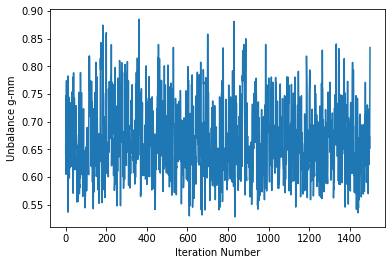

In [79]:
# Optimisation interation plot

plt.plot(iteration_number, unbalance)
plt.xlabel('Iteration Number')
plt.ylabel('Unbalance g-mm')
plt.show()


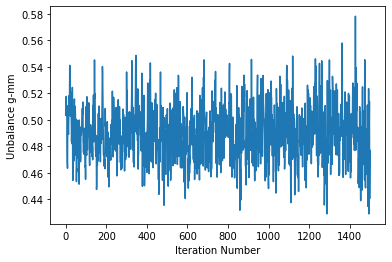

In [76]:
# Optimisation interation plot

plt.plot(iteration_number, favg_gen)
plt.xlabel('Iteration Number')
plt.ylabel('Unbalance g-mm')
plt.show()

In [80]:
radius = []
angle = []
breath = []
color = []
for i in range(len(best)):
    radius.append(Blade_data[best[i], 1])
    angle.append(i * 2 * 180 / len(best))
    breath.append(8)
    if (i % 2) == 0:
        colour = '#85EBFF'
    else:
        colour = '#405CFF'

    color.append(colour)

fig = go.Figure(go.Barpolar(
    r=radius,
    theta=angle,
    width=breath,
    marker_color=color,
    marker_line_color="black",
    marker_line_width=2,
    opacity=0.8
))
fig.update_layout(
    template=None,
    polar=dict(
        radialaxis=dict(range=[0, 2000], showticklabels=False, ticks=''),
        angularaxis=dict(showticklabels=False, ticks='')
    )
)
fig.show()
